In [14]:
# import pandas as pd
import cudf as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from tabulate import tabulate

In [15]:
# Load daily stock data

daily = pd.read_csv('data.csv')

daily

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AAAU,2020-12-31 05:00:00+00:00,18.90,18.9400,18.8300,18.94,283545.0,455.0,18.880037
1,AAAU,2021-01-04 05:00:00+00:00,19.33,19.3600,19.2243,19.35,772807.0,1191.0,19.313978
2,AAAU,2021-01-05 05:00:00+00:00,19.42,19.4400,19.3110,19.41,626939.0,768.0,19.389445
3,AAAU,2021-01-06 05:00:00+00:00,19.27,19.2734,18.9310,19.10,1427801.0,2218.0,19.108362
4,AAAU,2021-01-07 05:00:00+00:00,19.07,19.1000,18.9910,19.05,334353.0,631.0,19.060624
...,...,...,...,...,...,...,...,...,...
2712021,Z,2023-12-22 05:00:00+00:00,59.04,59.2900,58.4000,58.79,2631384.0,31006.0,58.832141
2712022,Z,2023-12-26 05:00:00+00:00,59.10,59.1000,58.3100,58.68,2753810.0,29849.0,58.656603
2712023,Z,2023-12-27 05:00:00+00:00,59.00,59.6843,58.5700,59.47,2038048.0,30214.0,59.364864
2712024,Z,2023-12-28 05:00:00+00:00,59.10,59.2300,58.4200,58.85,2872784.0,37481.0,58.837350


In [16]:
# Transformations

daily['timestamp'] = daily['timestamp'].astype(str).str[:10]
daily['timestamp'] = pd.to_datetime(daily['timestamp'])

daily['caldt'] = daily['timestamp'].dt.strftime("%Y-%m-%d")
daily['mdt'] = daily['timestamp'].dt.strftime("%Y-%m")

daily = daily[(daily['caldt'] >= '2021-01-01') & (daily['caldt'] <= '2023-12-31')]

daily = daily[['symbol','caldt','mdt','close']].copy()

daily = daily.sort_values(by=['symbol','caldt'])

daily = daily.reset_index(drop=True)

daily['ret'] = daily.groupby('symbol')['close'].pct_change()

daily

,symbol,caldt,mdt,close,ret
0,A,2021-01-04,2021-01,115.99,<NA>
1,A,2021-01-05,2021-01,116.94,0.008190361
2,A,2021-01-06,2021-01,120.14,0.02736446
3,A,2021-01-07,2021-01,123.34,0.026635592
4,A,2021-01-08,2021-01,124.22,0.007134749
...,...,...,...,...,...
2708667,ZYME,2023-12-22,2023-12,9.83,0.05472103
2708668,ZYME,2023-12-26,2023-12,10.68,0.08646999
2708669,ZYME,2023-12-27,2023-12,10.75,0.006554307
2708670,ZYME,2023-12-28,2023-12,10.70,-0.004651163


In [17]:
# Aggregation to monthly data

monthly = daily.groupby(['symbol','mdt'])[['caldt','close']].agg({'caldt': 'last','close': 'last'})

monthly = monthly.reset_index()

monthly

,symbol,mdt,caldt,close
0,A,2021-01,2021-01-29,117.48
1,A,2021-02,2021-02-26,119.34
2,A,2021-03,2021-03-31,124.30
3,A,2021-04,2021-04-30,130.85
4,A,2021-05,2021-05-28,135.24
...,...,...,...,...
129631,ZYME,2023-08,2023-08-31,7.24
129632,ZYME,2023-09,2023-09-29,6.34
129633,ZYME,2023-10,2023-10-31,7.02
129634,ZYME,2023-11,2023-11-30,8.87


In [18]:
# Generate features

monthly['ret'] = monthly.groupby('symbol')['close'].pct_change()

monthly['logret'] = np.log(1+monthly['ret'])

monthly['mom'] = monthly.groupby('symbol')['logret'].rolling(11,11).sum().reset_index(drop=True)

monthly['momlag'] = monthly.groupby('symbol')['mom'].shift(1)

monthly

,symbol,mdt,caldt,close,ret,logret,mom,momlag
0,A,2021-01,2021-01-29,117.48,<NA>,<NA>,<NA>,<NA>
1,A,2021-02,2021-02-26,119.34,0.015832482,0.015708456,<NA>,<NA>
2,A,2021-03,2021-03-31,124.30,0.041561924,0.040721436,<NA>,<NA>
3,A,2021-04,2021-04-30,130.85,0.052695093,0.05135363,<NA>,<NA>
4,A,2021-05,2021-05-28,135.24,0.033549866,0.032999349,<NA>,<NA>
...,...,...,...,...,...,...,...,...
129631,ZYME,2023-08,2023-08-31,7.24,-0.029490617,-0.029934208,0.163169125,0.151696143
129632,ZYME,2023-09,2023-09-29,6.34,-0.124309392,-0.132742438,-0.15864709,0.163169125
129633,ZYME,2023-10,2023-10-31,7.02,0.107255521,0.10188445,-0.095051146,-0.15864709
129634,ZYME,2023-11,2023-11-30,8.87,0.263532764,0.233911578,0.12088819,-0.095051146


In [19]:
# Trading filters

monthly['prclag'] = monthly.groupby('symbol')['close'].shift(1)

monthly = monthly.query('momlag == momlag and prclag >= 5')

# Portfolio generation

monthly['score'] = monthly.groupby('mdt')['momlag'].rank(ascending=False)

port = monthly[monthly['score'] <= 100].reset_index(drop=True).copy()

port

,symbol,mdt,caldt,close,ret,logret,mom,momlag,prclag,score
0,AA,2022-01,2022-01-31,55.32,-0.048176,-0.049375,0.839256,1.199167,58.12,25.0
1,AA,2022-02,2022-02-28,73.49,0.328453,0.284015,0.843360,0.839256,55.32,30.0
2,AA,2022-03,2022-03-31,87.92,0.196353,0.179278,0.902398,0.843360,73.49,31.0
3,AA,2022-04,2022-04-29,66.21,-0.246929,-0.283596,0.539320,0.902398,87.92,38.0
4,AA,2022-05,2022-05-31,60.38,-0.088053,-0.092174,0.521035,0.539320,66.21,70.0
...,...,...,...,...,...,...,...,...,...,...
2395,ZIM,2022-03,2022-03-31,43.73,0.271221,0.239978,0.951313,1.141981,34.40,15.0
2396,ZIM,2022-04,2022-04-29,33.46,-0.234850,-0.267684,0.469645,0.951313,43.73,32.0
2397,ZIM,2022-05,2022-05-31,39.90,0.192469,0.176026,0.677728,0.469645,33.46,99.0
2398,ZIM,2022-06,2022-06-30,29.59,-0.258396,-0.298940,0.516701,0.677728,39.90,50.0


In [20]:
# Merge portfolio with daily data to create backtest

port = port[['symbol','mdt','score']]

test = pd.merge(left=daily,right=port,on=['symbol','mdt'], how='inner')

test

,symbol,caldt,mdt,close,ret,score
0,AAON,2023-04-10,2023-04,62.47,0.016268,66.0
1,AAON,2023-04-11,2023-04,62.75,0.004482,66.0
2,AAON,2023-04-12,2023-04,63.95,0.019124,66.0
3,AAON,2023-04-13,2023-04,64.37,0.006568,66.0
4,AAON,2023-04-14,2023-04,63.27,-0.017089,66.0
...,...,...,...,...,...,...
50095,ZIM,2022-05-17,2022-05,39.12,-0.016591,99.0
50096,ZIM,2022-05-18,2022-05,36.87,-0.057515,99.0
50097,ZIM,2022-05-19,2022-05,38.35,0.040141,99.0
50098,ZIM,2022-05-20,2022-05,38.91,0.014602,99.0


In [21]:
# Backtest Transformations

test = test.groupby('caldt')['ret'].mean().to_frame().reset_index()

test = test.sort_values(by='caldt').reset_index(drop=True)

test['cumret'] = (1+test['ret']).cumprod() - 1

test

,caldt,ret,cumret
0,2022-01-03,0.004198,0.004198
1,2022-01-04,0.001365,0.005569
2,2022-01-05,-0.038933,-0.033581
3,2022-01-06,0.011678,-0.022295
4,2022-01-07,-0.022159,-0.043960
...,...,...,...
496,2023-12-22,0.008412,0.223013
497,2023-12-26,0.018225,0.245303
498,2023-12-27,0.011680,0.259847
499,2023-12-28,-0.010224,0.246966


In [22]:
# Load benchmark daily data

bmk = pd.read_csv('bmk.csv',index_col=False)

bmk

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,375.309998,375.450012,364.820007,368.790009,350.543579,110210800
1,2021-01-05,368.100006,372.500000,368.049988,371.329987,352.957916,66426200
2,2021-01-06,369.709991,376.980011,369.119995,373.549988,355.068054,107997700
3,2021-01-07,376.100006,379.899994,375.910004,379.100006,360.343445,68766800
4,2021-01-08,380.589996,381.489990,377.100006,381.260010,362.396576,71677200
...,...,...,...,...,...,...,...
748,2023-12-22,473.859985,475.380005,471.700012,473.649994,470.664490,67126600
749,2023-12-26,474.070007,476.579987,473.989990,475.649994,472.651886,55387000
750,2023-12-27,475.440002,476.660004,474.890015,476.510010,473.506500,68000300
751,2023-12-28,476.880005,477.549988,476.260010,476.690002,473.685333,77158100


In [23]:
# Transformations

bmk['Date'] = pd.to_datetime(bmk['Date'])

bmk['caldt'] = bmk['Date'].dt.strftime("%Y-%m-%d")
bmk['mdt'] = bmk['Date'].dt.strftime("%Y-%m")

bmk = bmk.rename(columns={'Adj Close': 'close'})

bmk = bmk[['caldt','mdt','close']]

bmk = bmk[bmk['caldt'] >= test['caldt'].min()]

bmk['ret'] = bmk['close'].pct_change()
bmk['cumret'] = (1+bmk['ret']).cumprod() - 1

bmk = bmk.drop(columns=['close', 'mdt'])

bmk = bmk.reset_index(drop = True)

bmk

,caldt,ret,cumret
0,2022-01-03,<NA>,<NA>
1,2022-01-04,-0.000334937,-0.000334937
2,2022-01-05,-0.019202182,-0.019530687
3,2022-01-06,-0.000939324,-0.020451665
4,2022-01-07,-0.003953526,-0.024324335
...,...,...,...
496,2023-12-22,0.002009706,0.022900554
497,2023-12-26,0.004222533,0.027219785
498,2023-12-27,0.001808126,0.029077128
499,2023-12-28,0.000377678,0.029465788


<Axes: xlabel='caldt', ylabel='cumret'>

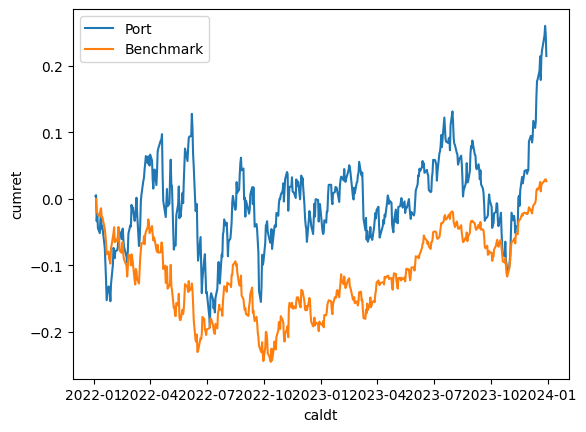

In [24]:
# Chart

test['caldt'] = pd.to_datetime(test['caldt'])
bmk['caldt'] = pd.to_datetime(bmk['caldt'])

test = test.to_pandas()
bmk = bmk.to_pandas()

sns.lineplot(data=test,x='caldt',y='cumret', label='Port')
sns.lineplot(data=bmk,x='caldt',y='cumret', label='Benchmark')

In [25]:
# Metrics

port_cumret = test['cumret'].iloc[-1] 
bmk_cumret = bmk['cumret'].iloc[-1]

port_ret = port_cumret / test['cumret'].count() * 250
bmk_ret = bmk_cumret / bmk['cumret'].count() * 250

port_vol = test['ret'].std()
bmk_vol = bmk['ret'].std()

port_er = test['ret'].mean()
bmk_er = bmk['ret'].mean()

correlation = test['ret'].corr(bmk['ret'])
covariance = test['ret'].cov(bmk['ret'])

beta = covariance / (bmk_vol**2)

In [26]:
# Create a table with the results
table = [
    ["Metric", "Portfolio", "Benchmark"],
    ["Total Return", f"% {round(port_cumret * 100, 2)}", f"% {round(bmk_cumret * 100, 2)}" ],
    ["Annual Return", f"% {round(port_ret * 100, 2)}", f"% {round(bmk_ret * 100, 2)}"],
    ["Expected Return", f"% {round(port_er * 100,2)}", f"% {round(bmk_er * 100,2)}"],
    ["Volatility", f"% {round(port_vol * 100,2)}", f"% {round(bmk_vol * 100,2)}"],
    ["Sharpe", f"{round((port_er / port_vol * 100),2)}", f"{round((bmk_er / bmk_vol * 100),2)}"],
    ["Correlation", round(correlation,2)],
    ["Beta", round(beta,2)]
]

# Print the table
print(tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------------+-------------+-------------+
| Metric          | Portfolio   | Benchmark   |
+=================+=============+=============+
| Total Return    | % 21.46     | % 2.65      |
+-----------------+-------------+-------------+
| Annual Return   | % 10.71     | % 1.32      |
+-----------------+-------------+-------------+
| Expected Return | % 0.06      | % 0.01      |
+-----------------+-------------+-------------+
| Volatility      | % 1.96      | % 1.23      |
+-----------------+-------------+-------------+
| Sharpe          | 2.96        | 1.04        |
+-----------------+-------------+-------------+
| Correlation     | 0.67        |             |
+-----------------+-------------+-------------+
| Beta            | 1.07        |             |
+-----------------+-------------+-------------+
